In [ ]:
# image preprocessing - columnize for base line
from os import makedirs, path, listdir
import numpy as np

from skimage import img_as_uint, img_as_ubyte, filters, measure, morphology, segmentation, color
from skimage.io import imread, imsave, imshow
from skimage.feature import canny
from skimage.filters import sobel, threshold_otsu
from skimage.transform import resize
from scipy.ndimage.morphology import distance_transform_edt
from scipy import ndimage as ndi

%matplotlib inline
import matplotlib.pyplot as plt
import time

class Map:#containing imformation of rectified contours
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.width = x_max - x_min
        self.height = y_max - y_min
        self.size = self.width * self.height
        self.centroid = [(self.x_min + self.x_max)/2, (self.y_min + self.y_max)/2]
        upper_left, upper_right, bottom_left, bottom_right = [self.y_max, self.x_min], [self.y_max, self.x_max], [self.y_min, self.x_min], [self.y_min, self.x_max]
        self.map = np.array([upper_left, upper_right, bottom_right, bottom_left, upper_left])#needs to be ndarray
        self.col = 0

def fillHoles(edges):
    edges = denoiseBoundary(edges, 5, 5)
    edges = ndi.binary_closing(edges)
    filled = ndi.binary_fill_holes(edges)
    
    return filled

def crop(img, area):
    y1 = int(area[2])
    y2 = int(area[3])
    x1 = int(area[0])
    x2 = int(area[1])
    return img[y1:y2, x1:x2]

def findIndices_x(arr):
    min_indice, max_indice = len(arr[0]), 0

    for i in range(0, len(arr)):
        row = arr[i]
        for j in range(0, len(row)):
            x = row[j]
            if(x == 255):
                if(max_indice < j):
                    max_indice = j
                if(j < min_indice):
                    min_indice = j
                    
    if(min_indice <= 20):
#         print("min x indice is ", min_indice)
        start_index = min_indice + 1
        min_indice = len(arr)
        for i in range(0, len(arr)):
            row = arr[i]
            for j in range(start_index, len(row)):
                x = row[j]
                if(x == 255):
                    if(j < min_indice):
                        if(j <= 20): continue
                        min_indice = j
                        
#     print("min x indice is now ", min_indice)
                        
    if(len(arr[0]) - max_indice <= 20):
#         print("max x indice is ", max_indice)
        start_index = min_indice + 1
        end_index = max_indice
        max_indice = start_index
        for i in range(0, len(arr)):
            row = arr[i]
            for j in range(start_index, end_index):
                x = row[j]
                if(x == 255):
                    if(max_indice < j):
                        if(len(arr[0]) - j <= 20): continue
                        max_indice = j
    
#     print("max x indice is now", max_indice)
    
    return (min_indice, max_indice)

def findIndices_y(arr):
    min_indice, max_indice = len(arr), 0

    for i in range(0, len(arr)):
        row = arr[i]
        has_x = False
        
        for j in range(0, len(row)):
            x = row[j]
            if(x == 255):
                has_x = True
                break;
                
        if(has_x):
            if(max_indice < i):
                 max_indice = i
            if(i < min_indice):
                min_indice = i
    
    if(min_indice <= 10):
#         print("min y indice is ", min_indice)
        start_index = min_indice + 1
        min_indice = len(arr)
        for i in range(start_index, len(arr)):
            row = arr[i]
            has_x = False

            for j in range(0, len(row)):
                x = row[j]
                if(x == 255):
                    has_x = True
                    break
                    
            if(has_x):
                if(i < min_indice):
                    if(i <= 10): continue
                    min_indice = i
    
#     print("min y indice is now ", min_indice)
    
    if(len(arr) - max_indice <= 10):
#         print("max y indice is ", max_indice)
        start_index = min_indice + 1
        end_index = max_indice
        max_indice = start_index
        for i in range(start_index, end_index):
            row = arr[i]
            has_x = False

            for j in range(0, len(row)):
                x = row[j]
                if(x == 255):
                    has_x = True
                    break
                    
            if(has_x):
                if(max_indice < i):
                    max_indice = i
    
#     print("max y indice is now", max_indice)
    
    return (min_indice, max_indice)

def columnize(img):
    h, w = img.shape
    middle_line = filters.median(img, selem=np.ones((h,1)))

    x_min, x_max = findIndices_x(middle_line)
    line_width = x_max - x_min
    col1, col2 = crop(img, [0, x_min, 0, h]), crop(img, [x_max, w, 0, h])
    
    return (col1, col2, line_width)

def parseArea(img):
    h, w = img.shape
    valid_map = filters.median(img, selem=np.ones((1,w)))
    
    y_min, y_max = findIndices_y(valid_map)
    
    header, body, footer = crop(img, [0, w, 0, y_min]), crop(img, [0, w, y_min, y_max]), crop(img, [0, w, y_max, h])
    
    return (header, body, footer, (y_min, y_max))

def denoiseBoundary(img, x_value, y_value):
    height, width = img.shape 
    
    for i in range(0, height):
        if(i <= y_value or height - i <= y_value):
            for j in range(0, width):
                img[i][j] = 0
        else:
            for j in range(0, x_value+1):
                img[i][j] = 0
            for j in range(width - x_value, width):
                img[i][j] = 0    
                
    return img

def denoiseEdge_R(img, x_value):
    height, width = img.shape
    
    for i in range(0, height):
        for j in range(width - x_value, width):
            img[i][j] = 0  
            
    return img

def denoiseEdge_L(img, x_value):
    height, width = img.shape 
    
    for i in range(0, height):
        for j in range(0, x_value):
            img[i][j] = 0
            
    return img

def scanRow(img, cords):
    x_min, x_max, y = cords
    
    for i in range(x_min, x_max+1):
        if(img[y][i] != 0): return True
    
    return False

def scanColumn(img, cords):
    y_min, y_max, x = cords
    
    for i in range(y_min, y_max+1):
        if(img[i][x] != 0): return True
    
    return False

def scanRow_kernal(img, cords, kernal_size):
    x_min, x_max, y_min = cords
    y_max = y_min + kernal_size
#     print("sr_k - y max : ", y_max)
    
    res = []
    
    for y in range(y_min, y_max):
        res_row = scanRow(img, (x_min, x_max, y))
        res.append(res_row)
    
#     print(res)
    for r in res:
        if(r): return True
    
    return False
                
def correctRow(img, cords):# returns 1 if it needs to move boundary left
    y_min, y_max, x = cords
    lidx, ridx = x, x
 
    while(scanColumn(img, (y_min, y_max, lidx))): lidx = lidx - 1
    while(scanColumn(img, (y_min, y_max, ridx))): ridx = ridx + 1
    
    loffset, roffset = abs(lidx - x), abs(ridx - x)
    
    if(loffset > roffset):
        return (-1, roffset)
    elif(roffset > loffset):
        return (1, loffset)
    else:
        return (0,0)

def correctColumn(img, cords):# returns 1 if it needs to move boundary upward
    x_min, x_max, y = cords
    uidx, didx = y, y
    
    while(scanRow(img, (x_min, x_max, uidx))): uidx = uidx - 1
    while(scanRow(img, (x_min, x_max, didx))): didx = didx + 1
    
    uoffset, doffset = abs(uidx - y), abs(didx - y)
    
    if(doffset > uoffset):
        return (1, uoffset)
    elif(uoffset > doffset):
        return (-1, doffset)
    else:
        return (0,0)

def correctContour(img, cords):
    x_min, x_max, y_min, y_max = cords
    
    corr_up = correctColumn(img, (x_min, x_max, y_min))
    if(corr_up[0] == 1): y_min = y_min - corr_up[1]
    elif(corr_up[0] == -1): y_min = y_min + corr_up[1]
    
    corr_r = correctRow(img, (y_min, y_max, x_max))
    if(corr_r[0] == 1): x_max = x_max - corr_r[1]
    elif(corr_r[0] == -1): x_max = x_max + corr_r[1]
        
    corr_d = correctColumn(img, (x_min, x_max, y_max))
    if(corr_d[0] == 1): y_max = y_max - corr_d[1]
    elif(corr_d[0] == -1): y_max = y_max + corr_d[1]   
    
    corr_l = correctRow(img, (y_min, y_max, x_min))
    if(corr_l[0] == 1): x_min = x_min - corr_l[1]
    elif(corr_l[0] == -1): x_min = x_min + corr_l[1]
        
    return (x_min, x_max, y_min, y_max)

def shrinkContour(img, cords):
    x_min, x_max, y_min, y_max = cords
    
    while(not scanRow(img, (x_min, x_max, y_min))):
        y_min = y_min + 1
    
    while(not scanColumn(img, (y_min, y_max, x_max))):
        x_max = x_max - 1
        
    while(not scanRow(img, (x_min, x_max, y_max))):
        y_max = y_max - 1
    
    while(not scanColumn(img, (y_min, y_max, x_min))):
        x_min = x_min + 1
        
    return Map(x_min-1, x_max+1, y_min-1, y_max+1)

def findUppermost(arr, height):   
    length = len(arr)
    m, mh = -1, height

    for i in range(0, length):
        h = arr[i].y_min
        if(h < mh):
            m = i
            mh = h
            
    uppermost = arr.pop(m)
    
    return uppermost

def sortVertically(cont_arr, height):
    sorted_arr = []
    
    for i in range(0, len(cont_arr)):
        cont = findUppermost(cont_arr, height)
        sorted_arr.append(cont)
        
    return sorted_arr

def getPixelCount(img):
    h, w = img.shape
    count = 0
    
    for y in range(0, h):
        for x in range(0, w):
            if(img[y][x] != 0): count = count + 1
#     print("count : ", count)
    return count

def denoiseContour(img, arr, th):
    if(th < 150): th = 150 # a standard character has 10 pixel width, height - that is, if there is only less than 15 char, ignore it.
    length = len(arr)
    denoised = []
    
    for i in range(0, length):
        target = arr[i]
        x_min, x_max, y_min, y_max = target.x_min, target.x_max, target.y_min, target.y_max
        w, h = x_max - x_min, y_max - y_min
        a = w * h
        if(a < th): continue
            
        target_img = crop(img, (x_min, x_max, y_min, y_max))     
        if(th <= getPixelCount(target_img)): denoised.append(arr[i])
    
    return denoised


def splitContour(img, arr, kernal_size):
    length = len(arr)
    new_cont = []
    
    for i in range(0, length):
        target = arr[i]
        x_min, x_max, y_min, y_max = target.x_min, target.x_max, target.y_min, target.y_max
        
        for y in range(y_min, y_max+1):
            if(y_max < y + kernal_size):
                new_cont.append(target)
                break
            if(not scanRow_kernal(img, (x_min, x_max, y), kernal_size)):
#                 print("splited in i(", i, ") where y is ", y)
                cont_upper = shrinkContour(img, (x_min, x_max, y_min, y))
                cont_lower = shrinkContour(img, (x_min, x_max, y + kernal_size, y_max))
                new_cont.append(cont_upper)
                new_cont.append(cont_lower)
                break
    
    return new_cont

def expendContour(cords, val):
    x_min, x_max, y_min, y_max = cords
    
    x_min = x_min - val
    x_max = x_max + val
    y_min = y_min - val
    y_max = y_max + val
    
    return Map(x_min, x_max, y_min, y_max)


def saveImage(img, cnt, file_name):
    new_dir_path = base_path + "parsed/" + file_name
    
    if not path.exists(new_dir_path):
        makedirs(new_dir_path)
    
    y, x = img.shape
    contour = Map(5, x-5, 5, y-5).map
    fig, ax = plt.subplots(figsize=(15,4))
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='g')
    ax.set_axis_off()
    fig.savefig(new_dir_path + '/' + file_name + '_' + str(cnt) + png, bbox_inches='tight', pad_inches = 0)

class Column:
    def __init__(self, img):
        self.image = img
        self.header, self.body, self.footer, __ = parseArea(img)
        
    def __delete(self, instance):
        del self.image
        del self.header, self.body, self.footer
    
    def showColumn(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.image, interpolation='nearest', cmap=plt.cm.gray)
        
    def showHeader(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.header, interpolation='nearest', cmap=plt.cm.gray)
        
    def showBody(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        h, w = self.body.shape
        ticks = [np.arange(0, w, 5), np.arange(0, h, 5)]
        ax.set_xticks(ticks[0])
        ax.set_yticks(ticks[1])
        ax.grid(which='both')
        ax.imshow(self.body, interpolation='nearest', cmap=plt.cm.gray)
    
    def showFooter(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.footer, interpolation='nearest', cmap=plt.cm.gray)
        
    def showAll(self):
        fig1, ax1 = plt.subplots(figsize=(30, 16))
        fig2, ax2 = plt.subplots(figsize=(30, 16))
        fig3, ax3 = plt.subplots(figsize=(30, 16))
        
        ax1.imshow(self.header, interpolation='nearest', cmap=plt.cm.gray)
        ax2.imshow(self.body, interpolation='nearest', cmap=plt.cm.gray)
        ax3.imshow(self.footer, interpolation='nearest', cmap=plt.cm.gray)
    
    def getColumn(self):
        height, width = self.image.shape
        return ((0,0), width, height)
    
    def getHeader(self):
        height, width = self.header.shape
        return ((0,0), width, height)
    
    def getBody(self):
        header = self.getHeader()
        h_header = header[2]
        h_body, w_body = self.body.shape
        p = (h_header, 0)
        return (p, w_body, h_body)
    
    def getFooter(self):
        body = self.getBody()
        h_body = body[2]
        p_body = body[0]
        h_footer, w_footer = self.footer.shape
        p_y, p_x = p_body[0] + h_body, 0
        p = (p_y, p_x)
        return (p, w_footer, h_footer)
    
    def getContour(self, col_flag):
#         fig, ax = plt.subplots(figsize=(30, 16))
#         fig2, ax2 = plt.subplots(figsize=(30, 16))
        __, w, h = self.getBody()
        ticks = [np.arange(0, w, 10), np.arange(0, h, 10)]
        ax.set_xticks(ticks[0])
        ax.set_yticks(ticks[1])
        ax.grid(which='both')

        vmap = fillHoles(self.body)
        if(col_flag == 2): vmap = denoiseEdge_R(vmap, 40)
        kernal_dilation = np.ones((10,10)) # normal text size
        vmap = ndi.binary_dilation(vmap, kernal_dilation).astype(np.uint8)
        
        kernal_dilation = np.ones((1,w)) # normal text size
        vmap = ndi.binary_dilation(vmap, kernal_dilation, 2).astype(np.uint8)
        
        vmap = vmap * 255
#         vmap = removeFirst(vmap)
        
        vmap = denoiseBoundary(vmap, 5, 10)
        if(col_flag == 1): vmap = denoiseEdge_L(vmap, 20)
        if(col_flag == 2): vmap = denoiseEdge_R(vmap, 40)
    
        contours = measure.find_contours(vmap, 1)#주어진 distance map으로 contour찾기.
        new_cont = []
        for n, contour in enumerate(contours):
            #check if there is any valid region in the boundary
            x_min, x_max, y_min, y_max = min(contour[:, 1]), max(contour[:, 1]), min(contour[:, 0]), max(contour[:, 0])
            x_min, x_max, y_min, y_max = int(round(x_min)), int(round(x_max)), int(round(y_min)), int(round(y_max))
            contour_width, contour_height = x_max - x_min, y_max - y_min
            x_min, x_max, y_min, y_max = correctContour(self.body, (x_min, x_max, y_min, y_max))
            corr_cont = Map(x_min, x_max, y_min, y_max)    
            new_cont.append(corr_cont)
                   
        new_cont = sortVertically(new_cont, h)
        new_cont = denoiseContour(self.body, new_cont, 500)
        
        shrinked = []
        for n_c in new_cont:
            c = n_c
            c = shrinkContour(self.body, (c.x_min, c.x_max, c.y_min, c.y_max))
            shrinked.append(c)
            
        new_cont = splitContour(self.body, shrinked, 12)
        new_cont.pop(0)#remove uppermost contour
        
        box_cont = []
        for c in new_cont:
            cords = (c.x_min, c.x_max, c.y_min, c.y_max)
            n_c = expendContour(cords, 5)
            box_cont.append(n_c)
        
        return (new_cont, box_cont)
               
class Page:
    def __init__(self, img):
        img = denoiseBoundary(img, 10, 8)
        col1, col2, line_gap = columnize(img)
        self.page = img
        self.mid_line = line_gap
        self.col1 = Column(col1)
        self.col2 = Column(col2)
        
    def __delete__(self, instance):
        del self.page, self.mid_line, self.col1, self.col2
        
        
    def showPage(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.page, interpolation='nearest', cmap=plt.cm.gray)
        
    def showColumn(self, i):
        if(i == 1): self.col1.showColumn()
        elif(i == 2): self.col2.showColumn()
    
    def showColumns(self):
        self.col1.showColumn()
        self.col2.showColumn()
    
    def showColumnCont(self, i, string):
        if(i == 1): 
            if(string == "header"): self.col1.showHeader()
            elif(string == "body"): self.col1.showBody()
            elif(string == "footer"): self.col1.showFooter()
            elif(string == "all"): self.col1.showAll()      
        elif(i == 2): 
            if(string == "header"): self.col2.showHeader()
            elif(string == "body"): self.col2.showBody()
            elif(string == "footer"): self.col2.showFooter()
            elif(string == "all"): self.col2.showAll()   
                
    def showColumnsCont(self):
        self.col1.showColumn()
        self.col1.showHeader()
        self.col1.showBody()
        self.col1.showFooter()
        self.col2.showColumn()
        self.col2.showHeader()
        self.col2.showBody()
        self.col2.showFooter()
           
      
    def getContour(self):
        cont_col1 = self.col1.getContour(1)
        cont_col2 = self.col2.getContour(2)
        p, w, h = self.col1.getHeader()
        
        cont, box = cont_col1
        new_cont_col1 = []
        new_box_col1 = []
        for i in range(0, len(cont)):
            x_min, x_max, y_min, y_max = cont[i].x_min, cont[i].x_max, cont[i].y_min + h, cont[i].y_max + h
            new_cont_col1.append(Map(x_min, x_max, y_min, y_max))
            x_min, x_max, y_min, y_max = box[i].x_min, box[i].x_max, box[i].y_min + h, box[i].y_max + h
            new_box_col1.append(Map(x_min, x_max, y_min, y_max))
            
        cont, box = cont_col2
        p, __, h = self.col2.getHeader()
        w = w + self.mid_line
        
        new_cont_col2 = []
        new_box_col2 = []
        for i in range(0, len(cont)):
            x_min, x_max, y_min, y_max = cont[i].x_min + w, cont[i].x_max + w, cont[i].y_min + h, cont[i].y_max + h
            new_cont_col2.append(Map(x_min, x_max, y_min, y_max))
            x_min, x_max, y_min, y_max = box[i].x_min + w, box[i].x_max + w, box[i].y_min + h, box[i].y_max + h
            new_box_col2.append(Map(x_min, x_max, y_min, y_max))
            
        package_col1, package_col2 = (new_cont_col1, new_box_col1), (new_cont_col2, new_box_col2)
        
        return (package_col1, package_col2)

case = ['case_a/', 'case_b/']
base_path = './resrc/capstone/'
src_dir = base_path + case[0]
png = '.png'

elements = listdir(src_dir)
f_list = []

for e in elements:
    f_list.append(e.split(".")[0])
    
pattern = 1
start_time = time.time()
for index, file_name in enumerate(f_list):
#     if(file_name != "071"): continue
    pattern += index
    pattern %= 4
    print(pattern, " Pattern")
    
    img = imread(src_dir + file_name + png, as_grey=True)
    img = resize(img, (640, 840))
    height_img, width_img = img.shape
    print("IMG = ", file_name, "( WIDTH : ", width_img, " HEIGHT : ", height_img, " )")
    
    edges = canny(img)
    
    p = Page(edges)
#     p.showColumnCont(1,"body")
#     p.showColumnCont(2,"body")
    col1, col2 = p.getContour()
    
    cont_col1, box_col1 = col1
    cont_col2, box_col2 = col2
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(60,16))
#     ticks = [np.arange(0, width_img, 10), np.arange(0, height_img, 10)]
#     ax.set_xticks(ticks[0])
#     ax.set_yticks(ticks[1])
#     ax.grid(which='both')
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    
    for ct in cont_col1:
        ct = ct.map
        ax.plot(ct[:, 1], ct[:, 0], linewidth=1, color='g')
        
    for ct in cont_col2:
        ct = ct.map
        ax.plot(ct[:, 1], ct[:, 0], linewidth=1, color='g')
        
    for i,b in enumerate(box_col1):
        x_min, x_max, y_min, y_max = b.x_min, b.x_max, b.y_min, b.y_max
        area = x_min, x_max, y_min, y_max
        res = crop(img, area)
        saveImage(res, i, file_name)
    
    j = len(box_col1)
    for i,b in enumerate(box_col2):
        x_min, x_max, y_min, y_max = b.x_min, b.x_max, b.y_min, b.y_max
        area = x_min, x_max, y_min, y_max
        res = crop(img, area)
        saveImage(res, i+j, file_name)
        
    plt.show()
    del p
print("--- %s seconds ---" %(time.time() - start_time))



    

C:\Users\Juyoung\Miniconda3\envs\venv\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


IMG =  016 ( WIDTH :  840  HEIGHT :  640  )


<Figure size 432x288 with 0 Axes>

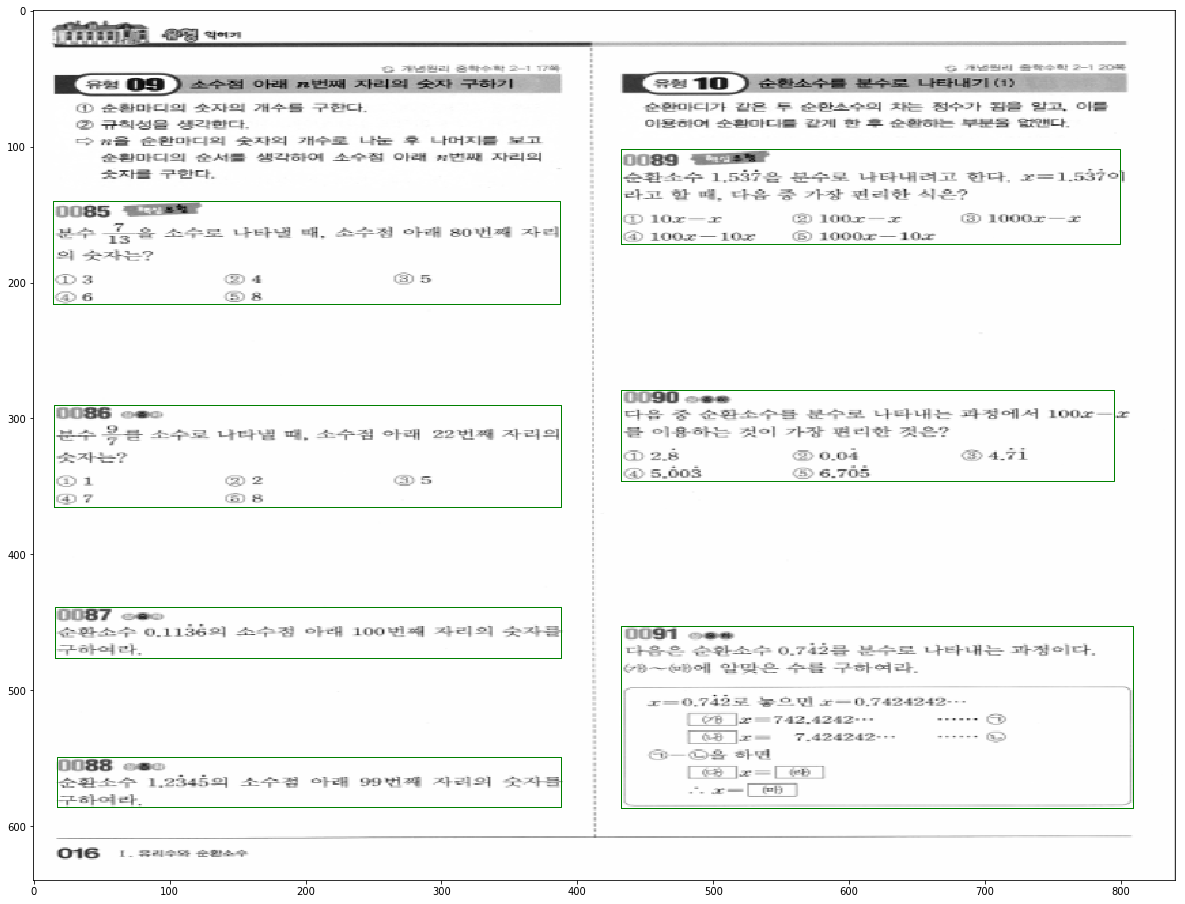

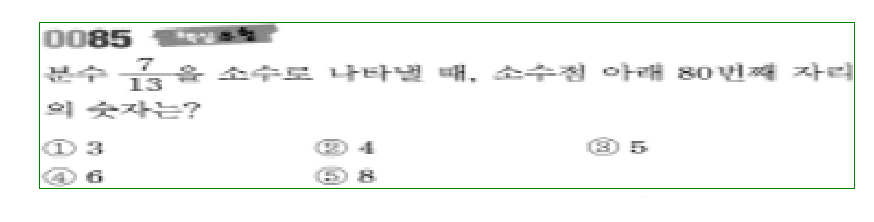

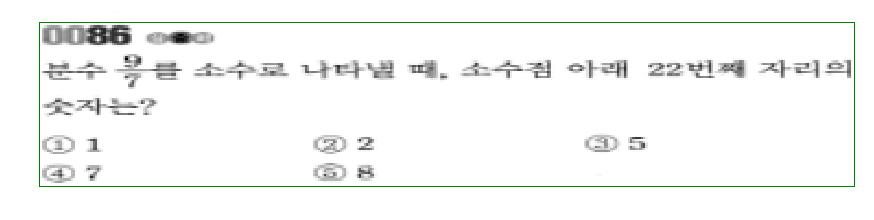

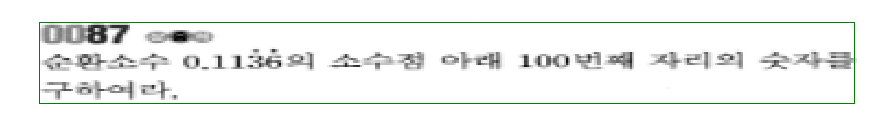

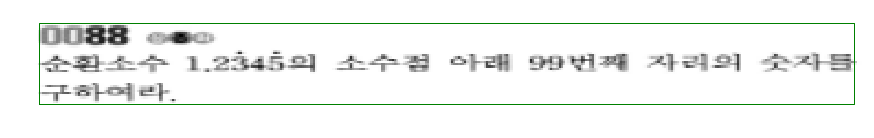

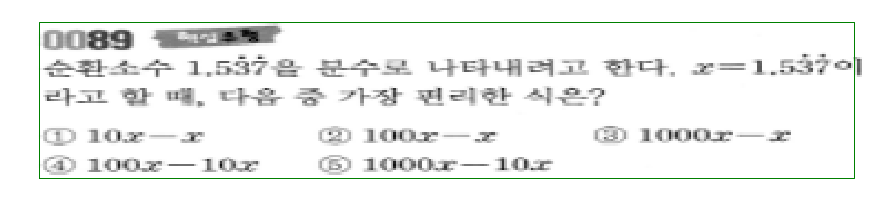

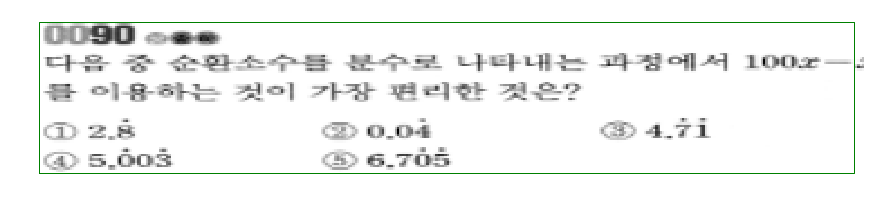

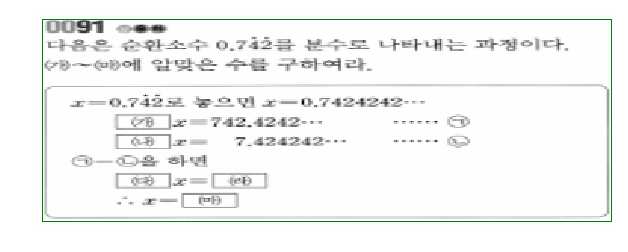

In [2]:
# image preprocessing - columnize for base line
from os import makedirs, path, listdir
import numpy as np

from skimage import img_as_uint, img_as_ubyte, filters, measure, morphology, segmentation, color
from skimage.io import imread, imsave, imshow
from skimage.feature import canny
from skimage.filters import sobel, threshold_otsu
from skimage.transform import resize
from scipy.ndimage.morphology import distance_transform_edt
from scipy import ndimage as ndi

%matplotlib inline
import matplotlib.pyplot as plt
import time

class Map:#containing imformation of rectified contours
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.width = x_max - x_min
        self.height = y_max - y_min
        self.size = self.width * self.height
        self.centroid = [(self.x_min + self.x_max)/2, (self.y_min + self.y_max)/2]
        upper_left, upper_right, bottom_left, bottom_right = [self.y_max, self.x_min], [self.y_max, self.x_max], [self.y_min, self.x_min], [self.y_min, self.x_max]
        self.map = np.array([upper_left, upper_right, bottom_right, bottom_left, upper_left])#needs to be ndarray
        self.col = 0

def fillHoles(edges):
    edges = denoiseBoundary(edges, 5, 5)
    edges = ndi.binary_closing(edges)
    filled = ndi.binary_fill_holes(edges)
    
    return filled

def crop(img, area):
    y1 = int(area[2])
    y2 = int(area[3])
    x1 = int(area[0])
    x2 = int(area[1])
    return img[y1:y2, x1:x2]

def findIndices_x(arr):
    min_indice, max_indice = len(arr[0]), 0

    for i in range(0, len(arr)):
        row = arr[i]
        for j in range(0, len(row)):
            x = row[j]
            if(x == 255):
                if(max_indice < j):
                    max_indice = j
                if(j < min_indice):
                    min_indice = j
                    
    if(min_indice <= 20):
#         print("min x indice is ", min_indice)
        start_index = min_indice + 1
        min_indice = len(arr)
        for i in range(0, len(arr)):
            row = arr[i]
            for j in range(start_index, len(row)):
                x = row[j]
                if(x == 255):
                    if(j < min_indice):
                        if(j <= 20): continue
                        min_indice = j
                        
#     print("min x indice is now ", min_indice)
                        
    if(len(arr[0]) - max_indice <= 20):
#         print("max x indice is ", max_indice)
        start_index = min_indice + 1
        end_index = max_indice
        max_indice = start_index
        for i in range(0, len(arr)):
            row = arr[i]
            for j in range(start_index, end_index):
                x = row[j]
                if(x == 255):
                    if(max_indice < j):
                        if(len(arr[0]) - j <= 20): continue
                        max_indice = j
    
#     print("max x indice is now", max_indice)
    
    return (min_indice, max_indice)

def findIndices_y(arr):
    min_indice, max_indice = len(arr), 0

    for i in range(0, len(arr)):
        row = arr[i]
        has_x = False
        
        for j in range(0, len(row)):
            x = row[j]
            if(x == 255):
                has_x = True
                break;
                
        if(has_x):
            if(max_indice < i):
                 max_indice = i
            if(i < min_indice):
                min_indice = i
    
    if(min_indice <= 10):
#         print("min y indice is ", min_indice)
        start_index = min_indice + 1
        min_indice = len(arr)
        for i in range(start_index, len(arr)):
            row = arr[i]
            has_x = False

            for j in range(0, len(row)):
                x = row[j]
                if(x == 255):
                    has_x = True
                    break
                    
            if(has_x):
                if(i < min_indice):
                    if(i <= 10): continue
                    min_indice = i
    
#     print("min y indice is now ", min_indice)
    
    if(len(arr) - max_indice <= 10):
#         print("max y indice is ", max_indice)
        start_index = min_indice + 1
        end_index = max_indice
        max_indice = start_index
        for i in range(start_index, end_index):
            row = arr[i]
            has_x = False

            for j in range(0, len(row)):
                x = row[j]
                if(x == 255):
                    has_x = True
                    break
                    
            if(has_x):
                if(max_indice < i):
                    max_indice = i
    
#     print("max y indice is now", max_indice)
    
    return (min_indice, max_indice)

def columnize(img):
    h, w = img.shape
    middle_line = filters.median(img, selem=np.ones((h,1)))

    x_min, x_max = findIndices_x(middle_line)
    line_width = x_max - x_min
    col1, col2 = crop(img, [0, x_min, 0, h]), crop(img, [x_max, w, 0, h])
    
    return (col1, col2, line_width)

def parseArea(img):
    h, w = img.shape
    valid_map = filters.median(img, selem=np.ones((1,w)))
    
    y_min, y_max = findIndices_y(valid_map)
    
    header, body, footer = crop(img, [0, w, 0, y_min]), crop(img, [0, w, y_min, y_max]), crop(img, [0, w, y_max, h])
    
    return (header, body, footer, (y_min, y_max))

def denoiseBoundary(img, x_value, y_value):
    height, width = img.shape 
    
    for i in range(0, height):
        if(i <= y_value or height - i <= y_value):
            for j in range(0, width):
                img[i][j] = 0
        else:
            for j in range(0, x_value+1):
                img[i][j] = 0
            for j in range(width - x_value, width):
                img[i][j] = 0    
                
    return img

def denoiseEdge_R(img, x_value):
    height, width = img.shape
    
    for i in range(0, height):
        for j in range(width - x_value, width):
            img[i][j] = 0  
            
    return img

def denoiseEdge_L(img, x_value):
    height, width = img.shape 
    
    for i in range(0, height):
        for j in range(0, x_value):
            img[i][j] = 0
            
    return img

def scanRow(img, cords):
    x_min, x_max, y = cords
    
    for i in range(x_min, x_max+1):
        if(img[y][i] != 0): return True
    
    return False

def scanColumn(img, cords):
    y_min, y_max, x = cords
    
    for i in range(y_min, y_max+1):
        if(img[i][x] != 0): return True
    
    return False

def scanRow_kernal(img, cords, kernal_size):
    x_min, x_max, y_min = cords
    y_max = y_min + kernal_size
#     print("sr_k - y max : ", y_max)
    
    res = []
    
    for y in range(y_min, y_max):
        res_row = scanRow(img, (x_min, x_max, y))
        res.append(res_row)
    
#     print(res)
    for r in res:
        if(r): return True
    
    return False
                
def correctRow(img, cords):# returns 1 if it needs to move boundary left
    y_min, y_max, x = cords
    lidx, ridx = x, x
 
    while(scanColumn(img, (y_min, y_max, lidx))): lidx = lidx - 1
    while(scanColumn(img, (y_min, y_max, ridx))): ridx = ridx + 1
    
    loffset, roffset = abs(lidx - x), abs(ridx - x)
    
    if(loffset > roffset):
        return (-1, roffset)
    elif(roffset > loffset):
        return (1, loffset)
    else:
        return (0,0)

def correctColumn(img, cords):# returns 1 if it needs to move boundary upward
    x_min, x_max, y = cords
    uidx, didx = y, y
    
    while(scanRow(img, (x_min, x_max, uidx))): uidx = uidx - 1
    while(scanRow(img, (x_min, x_max, didx))): didx = didx + 1
    
    uoffset, doffset = abs(uidx - y), abs(didx - y)
    
    if(doffset > uoffset):
        return (1, uoffset)
    elif(uoffset > doffset):
        return (-1, doffset)
    else:
        return (0,0)

def correctContour(img, cords):
    x_min, x_max, y_min, y_max = cords
    
    corr_up = correctColumn(img, (x_min, x_max, y_min))
    if(corr_up[0] == 1): y_min = y_min - corr_up[1]
    elif(corr_up[0] == -1): y_min = y_min + corr_up[1]
    
    corr_r = correctRow(img, (y_min, y_max, x_max))
    if(corr_r[0] == 1): x_max = x_max - corr_r[1]
    elif(corr_r[0] == -1): x_max = x_max + corr_r[1]
        
    corr_d = correctColumn(img, (x_min, x_max, y_max))
    if(corr_d[0] == 1): y_max = y_max - corr_d[1]
    elif(corr_d[0] == -1): y_max = y_max + corr_d[1]   
    
    corr_l = correctRow(img, (y_min, y_max, x_min))
    if(corr_l[0] == 1): x_min = x_min - corr_l[1]
    elif(corr_l[0] == -1): x_min = x_min + corr_l[1]
        
    return (x_min, x_max, y_min, y_max)

def shrinkContour(img, cords):
    x_min, x_max, y_min, y_max = cords
    
    while(not scanRow(img, (x_min, x_max, y_min))):
        y_min = y_min + 1
    
    while(not scanColumn(img, (y_min, y_max, x_max))):
        x_max = x_max - 1
        
    while(not scanRow(img, (x_min, x_max, y_max))):
        y_max = y_max - 1
    
    while(not scanColumn(img, (y_min, y_max, x_min))):
        x_min = x_min + 1
        
    return Map(x_min-1, x_max+1, y_min-1, y_max+1)

def findUppermost(arr, height):   
    length = len(arr)
    m, mh = -1, height

    for i in range(0, length):
        h = arr[i].y_min
        if(h < mh):
            m = i
            mh = h
            
    uppermost = arr.pop(m)
    
    return uppermost

def sortVertically(cont_arr, height):
    sorted_arr = []
    
    for i in range(0, len(cont_arr)):
        cont = findUppermost(cont_arr, height)
        sorted_arr.append(cont)
        
    return sorted_arr

def getPixelCount(img):
    h, w = img.shape
    count = 0
    
    for y in range(0, h):
        for x in range(0, w):
            if(img[y][x] != 0): count = count + 1
#     print("count : ", count)
    return count

def denoiseContour(img, arr, th):
    if(th < 150): th = 150 # a standard character has 10 pixel width, height - that is, if there is only less than 15 char, ignore it.
    length = len(arr)
    denoised = []
    
    for i in range(0, length):
        target = arr[i]
        x_min, x_max, y_min, y_max = target.x_min, target.x_max, target.y_min, target.y_max
        w, h = x_max - x_min, y_max - y_min
        a = w * h
        if(a < th): continue
            
        target_img = crop(img, (x_min, x_max, y_min, y_max))     
        if(th <= getPixelCount(target_img)): denoised.append(arr[i])
    
    return denoised


def splitContour(img, arr, kernal_size):
    length = len(arr)
    new_cont = []
    
    for i in range(0, length):
        target = arr[i]
        x_min, x_max, y_min, y_max = target.x_min, target.x_max, target.y_min, target.y_max
        
        for y in range(y_min, y_max+1):
            if(y_max < y + kernal_size):
                new_cont.append(target)
                break
            if(not scanRow_kernal(img, (x_min, x_max, y), kernal_size)):
#                 print("splited in i(", i, ") where y is ", y)
                cont_upper = shrinkContour(img, (x_min, x_max, y_min, y))
                cont_lower = shrinkContour(img, (x_min, x_max, y + kernal_size, y_max))
                new_cont.append(cont_upper)
                new_cont.append(cont_lower)
                break
    
    return new_cont

def expendContour(cords, val):
    x_min, x_max, y_min, y_max = cords
    
    x_min = x_min - val
    x_max = x_max + val
    y_min = y_min - val
    y_max = y_max + val
    
    return Map(x_min, x_max, y_min, y_max)


def saveImage(img, cnt, file_name):
    new_dir_path = base_path + "test/" + file_name
    
    if not path.exists(new_dir_path):
        makedirs(new_dir_path)
    
    y, x = img.shape
    contour = Map(5, x-5, 5, y-5).map
    fig, ax = plt.subplots(figsize=(15,4))
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='g')
    ax.set_axis_off()
    fig.savefig(new_dir_path + '/' + file_name + '_' + str(cnt) + png, bbox_inches='tight', pad_inches = 0)

class Column:
    def __init__(self, img):
        self.image = img
        self.header, self.body, self.footer, __ = parseArea(img)
        
    def __delete(self, instance):
        del self.image
        del self.header, self.body, self.footer
    
    def showColumn(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.image, interpolation='nearest', cmap=plt.cm.gray)
        
    def showHeader(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.header, interpolation='nearest', cmap=plt.cm.gray)
        
    def showBody(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        h, w = self.body.shape
        ticks = [np.arange(0, w, 5), np.arange(0, h, 5)]
        ax.set_xticks(ticks[0])
        ax.set_yticks(ticks[1])
        ax.grid(which='both')
        ax.imshow(self.body, interpolation='nearest', cmap=plt.cm.gray)
    
    def showFooter(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.footer, interpolation='nearest', cmap=plt.cm.gray)
        
    def showAll(self):
        fig1, ax1 = plt.subplots(figsize=(30, 16))
        fig2, ax2 = plt.subplots(figsize=(30, 16))
        fig3, ax3 = plt.subplots(figsize=(30, 16))
        
        ax1.imshow(self.header, interpolation='nearest', cmap=plt.cm.gray)
        ax2.imshow(self.body, interpolation='nearest', cmap=plt.cm.gray)
        ax3.imshow(self.footer, interpolation='nearest', cmap=plt.cm.gray)
    
    def getColumn(self):
        height, width = self.image.shape
        return ((0,0), width, height)
    
    def getHeader(self):
        height, width = self.header.shape
        return ((0,0), width, height)
    
    def getBody(self):
        header = self.getHeader()
        h_header = header[2]
        h_body, w_body = self.body.shape
        p = (h_header, 0)
        return (p, w_body, h_body)
    
    def getFooter(self):
        body = self.getBody()
        h_body = body[2]
        p_body = body[0]
        h_footer, w_footer = self.footer.shape
        p_y, p_x = p_body[0] + h_body, 0
        p = (p_y, p_x)
        return (p, w_footer, h_footer)
    
    def getContour(self, col_flag):
#         fig, ax = plt.subplots(figsize=(30, 16))
#         fig2, ax2 = plt.subplots(figsize=(30, 16))
        __, w, h = self.getBody()
#         ticks = [np.arange(0, w, 10), np.arange(0, h, 10)]
#         ax.set_xticks(ticks[0])
#         ax.set_yticks(ticks[1])
#         ax.grid(which='both')

        vmap = fillHoles(self.body)
        if(col_flag == 2): vmap = denoiseEdge_R(vmap, 40)
        kernal_dilation = np.ones((10,10)) # normal text size
        vmap = ndi.binary_dilation(vmap, kernal_dilation).astype(np.uint8)
        
        kernal_dilation = np.ones((1,w)) # normal text size
        vmap = ndi.binary_dilation(vmap, kernal_dilation, 2).astype(np.uint8)
        
        vmap = vmap * 255
#         vmap = removeFirst(vmap)
        
        vmap = denoiseBoundary(vmap, 5, 10)
        if(col_flag == 1): vmap = denoiseEdge_L(vmap, 20)
        if(col_flag == 2): vmap = denoiseEdge_R(vmap, 40)
    
        contours = measure.find_contours(vmap, 1)#주어진 distance map으로 contour찾기.
        new_cont = []
        for n, contour in enumerate(contours):
            #check if there is any valid region in the boundary
            x_min, x_max, y_min, y_max = min(contour[:, 1]), max(contour[:, 1]), min(contour[:, 0]), max(contour[:, 0])
            x_min, x_max, y_min, y_max = int(round(x_min)), int(round(x_max)), int(round(y_min)), int(round(y_max))
            contour_width, contour_height = x_max - x_min, y_max - y_min
            x_min, x_max, y_min, y_max = correctContour(self.body, (x_min, x_max, y_min, y_max))
            corr_cont = Map(x_min, x_max, y_min, y_max)    
            new_cont.append(corr_cont)
                   
        new_cont = sortVertically(new_cont, h)
        new_cont = denoiseContour(self.body, new_cont, 500)
        
        shrinked = []
        for n_c in new_cont:
            c = n_c
            c = shrinkContour(self.body, (c.x_min, c.x_max, c.y_min, c.y_max))
            shrinked.append(c)
            
        new_cont = splitContour(self.body, shrinked, 12)
        new_cont.pop(0)#remove uppermost contour
        
        box_cont = []
        for c in new_cont:
            cords = (c.x_min, c.x_max, c.y_min, c.y_max)
            n_c = expendContour(cords, 5)
            box_cont.append(n_c)
        
        return (new_cont, box_cont)
               
class Page:
    def __init__(self, img):
        img = denoiseBoundary(img, 10, 8)
        col1, col2, line_gap = columnize(img)
        self.page = img
        self.mid_line = line_gap
        self.col1 = Column(col1)
        self.col2 = Column(col2)
        
    def __delete__(self, instance):
        del self.page, self.mid_line, self.col1, self.col2
        
        
    def showPage(self):
        fig, ax = plt.subplots(figsize=(30, 16))
        ax.imshow(self.page, interpolation='nearest', cmap=plt.cm.gray)
        
    def showColumn(self, i):
        if(i == 1): self.col1.showColumn()
        elif(i == 2): self.col2.showColumn()
    
    def showColumns(self):
        self.col1.showColumn()
        self.col2.showColumn()
    
    def showColumnCont(self, i, string):
        if(i == 1): 
            if(string == "header"): self.col1.showHeader()
            elif(string == "body"): self.col1.showBody()
            elif(string == "footer"): self.col1.showFooter()
            elif(string == "all"): self.col1.showAll()      
        elif(i == 2): 
            if(string == "header"): self.col2.showHeader()
            elif(string == "body"): self.col2.showBody()
            elif(string == "footer"): self.col2.showFooter()
            elif(string == "all"): self.col2.showAll()   
                
    def showColumnsCont(self):
        self.col1.showColumn()
        self.col1.showHeader()
        self.col1.showBody()
        self.col1.showFooter()
        self.col2.showColumn()
        self.col2.showHeader()
        self.col2.showBody()
        self.col2.showFooter()
           
      
    def getContour(self):
        cont_col1 = self.col1.getContour(1)
        cont_col2 = self.col2.getContour(2)
        p, w, h = self.col1.getHeader()
        
        cont, box = cont_col1
        new_cont_col1 = []
        new_box_col1 = []
        for i in range(0, len(cont)):
            x_min, x_max, y_min, y_max = cont[i].x_min, cont[i].x_max, cont[i].y_min + h, cont[i].y_max + h
            new_cont_col1.append(Map(x_min, x_max, y_min, y_max))
            x_min, x_max, y_min, y_max = box[i].x_min, box[i].x_max, box[i].y_min + h, box[i].y_max + h
            new_box_col1.append(Map(x_min, x_max, y_min, y_max))
            
        cont, box = cont_col2
        p, __, h = self.col2.getHeader()
        w = w + self.mid_line
        
        new_cont_col2 = []
        new_box_col2 = []
        for i in range(0, len(cont)):
            x_min, x_max, y_min, y_max = cont[i].x_min + w, cont[i].x_max + w, cont[i].y_min + h, cont[i].y_max + h
            new_cont_col2.append(Map(x_min, x_max, y_min, y_max))
            x_min, x_max, y_min, y_max = box[i].x_min + w, box[i].x_max + w, box[i].y_min + h, box[i].y_max + h
            new_box_col2.append(Map(x_min, x_max, y_min, y_max))
            
        package_col1, package_col2 = (new_cont_col1, new_box_col1), (new_cont_col2, new_box_col2)
        
        return (package_col1, package_col2)

base_path = './resrc/capstone/'
src_dir = base_path + 'pool/'
png = '.png'

start_time = time.time()

#     if(file_name != "071"): continue
file_name = '016'
img = imread(src_dir + file_name + png, as_grey=True)
img = resize(img, (640, 840))
height_img, width_img = img.shape
print("IMG = ", file_name, "( WIDTH : ", width_img, " HEIGHT : ", height_img, " )")
    
edges = canny(img)
    
p = Page(edges)
#     p.showColumnCont(1,"body")
#     p.showColumnCont(2,"body")
col1, col2 = p.getContour()
    
cont_col1, box_col1 = col1
cont_col2, box_col2 = col2
    
plt.figure()
fig, ax = plt.subplots(figsize=(60,16))
#     ticks = [np.arange(0, width_img, 10), np.arange(0, height_img, 10)]
#     ax.set_xticks(ticks[0])
#     ax.set_yticks(ticks[1])
#     ax.grid(which='both')
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    
for ct in cont_col1:
    ct = ct.map
    ax.plot(ct[:, 1], ct[:, 0], linewidth=1, color='g')
        
for ct in cont_col2:
    ct = ct.map
    ax.plot(ct[:, 1], ct[:, 0], linewidth=1, color='g')
        
for i,b in enumerate(box_col1):
    x_min, x_max, y_min, y_max = b.x_min, b.x_max, b.y_min, b.y_max
    area = x_min, x_max, y_min, y_max
    res = crop(img, area)
    saveImage(res, i, file_name)
    
j = len(box_col1)
for i,b in enumerate(box_col2):
    x_min, x_max, y_min, y_max = b.x_min, b.x_max, b.y_min, b.y_max
    area = x_min, x_max, y_min, y_max
    res = crop(img, area)
    saveImage(res, i+j, file_name)
        
plt.show()
# print("--- %s seconds ---" %(time.time() - start_time))



    